In [1]:
!pip install opencv-contrib-python==3.4.0.12 
# otherwise you'd get an error message saying this when you try to use SIFT
# This algorithm is patented and is excluded in this configuration; 
# Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in 
# function 'cv::xfeatures2d::SIFT::create'

     |████████████████████████████████| 30.5MB 149kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
import numpy as np
import pandas as pd

from scipy import ndimage, signal
from scipy.ndimage import gaussian_filter
from copy import deepcopy
import matplotlib.pyplot as plt

import random
import math
import os

!pip install opencv-python
import cv2

import plotly.graph_objects as go

from google.colab.patches import cv2_imshow

In [3]:
GAUSSIAN_BLUR_SIGMA=1

In [4]:
def compute_gaussian_subsample(image:np.ndarray, factor:int=2) -> np.ndarray:
    temp_image = gaussian_filter(deepcopy(image), sigma=GAUSSIAN_BLUR_SIGMA)

    len_x = temp_image.shape[0]
    len_y = temp_image.shape[1]
    half_len_x = int(len_x/2)
    half_len_y = int(len_y/2)

    #gaussian_pyramid = [temp_image]

    # Subsample then blur as the first image has already been blurred

    # Subsample every other pixel
    temp_image = deepcopy(temp_image[::factor,::factor])

    # Gaussain blur
    temp_image = gaussian_filter(temp_image, sigma=GAUSSIAN_BLUR_SIGMA)

    #gaussian_pyramid.append(temp_image)

    # len_x = temp_image.shape[0]
    # len_y = temp_image.shape[1]
    # half_len_x = int(len_x/2)
    # half_len_y = int(len_y/2)

    return temp_image

In [47]:
def get_images(path0, path1, factor=2):
  img0 = cv2.imread(path0, cv2.IMREAD_GRAYSCALE)
  img1 = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)

  # subsample because current imgs too big
  img0 = compute_gaussian_subsample(img0,factor)
  img1 = compute_gaussian_subsample(img1,factor)

  #plt.subplot(1, 2, 1)
  #plt.imshow(img0, cmap='gray')
  #plt.subplot(1, 2, 2)
  #plt.imshow(img1, cmap='gray')
  

  return img0, img1

#get_images()

In [6]:
def perform_SIFT(img1, img2, threshold=0.5):
  # temp naming everything SIFT
  sift = cv2.xfeatures2d.SIFT_create()
  kp1_SIFT, desc1_SIFT = sift.detectAndCompute(img1, None)
  kp2_SIFT, desc2_SIFT = sift.detectAndCompute(img2, None)

  # surf = cv2.xfeatures2d.SURF_create()
  # kp1_SIFT, desc1_SIFT = surf.detectAndCompute(img1, None)
  # kp2_SIFT, desc2_SIFT = surf.detectAndCompute(img2, None)

  # orb = cv2.ORB_create(nfeatures=1000)
  # kp1_SIFT, desc1_SIFT = orb.detectAndCompute(img1, None)
  # kp2_SIFT, desc2_SIFT = orb.detectAndCompute(img2, None)

  img1_SIFT = cv2.drawKeypoints(img1, kp1_SIFT, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, color=(255,255,0))
  img2_SIFT = cv2.drawKeypoints(img2, kp1_SIFT, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, color=(255,255,0))

  #plt.figure()
  #fig, axs = plt.subplots(2,figsize=(10,10))
  #axs[0].imshow(img1_SIFT)
  #plt.subplot(1, 2, 2)
  #axs[1].imshow(img2_SIFT)
  #plt.show()

  kp1 = kp1_SIFT
  kp2 = kp2_SIFT
  desc1 = desc1_SIFT
  desc2 = desc2_SIFT

  bf = cv2.BFMatcher()
  matches = bf.knnMatch(desc1, desc2, k=2) # k=2 means find the top two matchs for each query descriptor

  # Apply ratio test (as per David Lowe's SIFT paper: compare the best match with the 2nd best match_
  good_matches = []
  good_matches_without_list = []
  for m,n in matches:
      if m.distance < threshold*n.distance: # only accept matchs that are considerably better than the 2nd best match
          good_matches.append([m])
          good_matches_without_list.append(m) # this is to simplify finding a homography later

  plt.figure()
  img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good_matches,
                          None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, 
                          matchColor=(0,255,0))
  plt.figure(figsize = (10,10))
  plt.imshow(img3), plt.show()

  src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches_without_list ]).reshape(-1,1,2)
  dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches_without_list ]).reshape(-1,1,2)

  return src_pts, dst_pts

def perform_SURF(img1, img2, threshold=0.5):
  # temp naming everything SIFT
  # sift = cv2.xfeatures2d.SIFT_create()
  # kp1_SIFT, desc1_SIFT = sift.detectAndCompute(img1, None)
  # kp2_SIFT, desc2_SIFT = sift.detectAndCompute(img2, None)

  surf = cv2.xfeatures2d.SURF_create()
  kp1_SIFT, desc1_SIFT = surf.detectAndCompute(img1, None)
  kp2_SIFT, desc2_SIFT = surf.detectAndCompute(img2, None)

  # orb = cv2.ORB_create(nfeatures=1000)
  # kp1_SIFT, desc1_SIFT = orb.detectAndCompute(img1, None)
  # kp2_SIFT, desc2_SIFT = orb.detectAndCompute(img2, None)

  img1_SIFT = cv2.drawKeypoints(img1, kp1_SIFT, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, color=(255,255,0))
  img2_SIFT = cv2.drawKeypoints(img2, kp1_SIFT, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, color=(255,255,0))

  #plt.figure()
  #fig, axs = plt.subplots(2,figsize=(10,10))
  #axs[0].imshow(img1_SIFT)
  #plt.subplot(1, 2, 2)
  #axs[1].imshow(img2_SIFT)
  #plt.show()

  kp1 = kp1_SIFT
  kp2 = kp2_SIFT
  desc1 = desc1_SIFT
  desc2 = desc2_SIFT

  bf = cv2.BFMatcher()
  matches = bf.knnMatch(desc1, desc2, k=2) # k=2 means find the top two matchs for each query descriptor

  # Apply ratio test (as per David Lowe's SIFT paper: compare the best match with the 2nd best match_
  good_matches = []
  good_matches_without_list = []
  for m,n in matches:
      if m.distance < threshold*n.distance: # only accept matchs that are considerably better than the 2nd best match
          good_matches.append([m])
          good_matches_without_list.append(m) # this is to simplify finding a homography later

  plt.figure()
  img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good_matches,
                          None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, 
                          matchColor=(0,255,0))
  plt.figure(figsize = (10,10))
  plt.imshow(img3), plt.show()

  src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches_without_list ]).reshape(-1,1,2)
  dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches_without_list ]).reshape(-1,1,2)

  return src_pts, dst_pts

In [28]:
def extract_calibration_vals(file, image_numbers):
    image1, image2 = image_numbers

    calib_vals = {}
    temple_par = pd.read_csv(file, delimiter=' ', dtype=str, skiprows=[0], index_col=0, header=None)
    temple_par.columns = ['k11', 'k12', 'k13', 'k21', 'k22', 'k23', 
                          'k31', 'k32', 'k33', 'r11', 'r12', 'r13', 
                          'r21', 'r22', 'r23', 'r31', 'r32', 'r33', 
                          't1', 't2', 't3']
    temple_par.index.name = 'image name'
    K0 = temple_par.iloc[image1,0:9].values.reshape(3,3).astype(float)
    R0 = temple_par.iloc[image1,9:18].values.reshape(3,3).astype(float)
    t0 = temple_par.iloc[image1,18:].values.reshape(3,1).astype(float)
    K1 = temple_par.iloc[image2,0:9].values.reshape(3,3).astype(float)
    R1 = temple_par.iloc[image2,9:18].values.reshape(3,3).astype(float)
    t1 = temple_par.iloc[image2,18:].values.reshape(3,1).astype(float)
    calib_vals['cam0'] = K0
    calib_vals['cam1'] = K1
    calib_vals['R0'] = R0
    calib_vals['R1'] = R1
    calib_vals['t0'] = t0
    calib_vals['t1'] = t1
    calib_vals['baseline'] = np.linalg.norm(t1 - t0)
    return calib_vals

In [8]:
def remove_outliers(world_coord):
  mean_coord = np.array([np.mean(world_coord[:,0]), np.mean(world_coord[:,1]), np.mean(world_coord[:,2])])
  stdev_coord = np.array([np.std(world_coord[:,0]), np.std(world_coord[:,1]), np.std(world_coord[:,2])])

  world_coord = world_coord[(world_coord[:,0] > mean_coord[0] - 3*stdev_coord[0]) & (world_coord[:,0] < mean_coord[0] + 3*stdev_coord[0])]
  world_coord = world_coord[(world_coord[:,1] > mean_coord[1] - 3*stdev_coord[1]) & (world_coord[:,1] < mean_coord[1] + 3*stdev_coord[1])]
  world_coord = world_coord[(world_coord[:,2] > mean_coord[2] - 3*stdev_coord[2]) & (world_coord[:,2] < mean_coord[2] + 3*stdev_coord[2])]

  return world_coord

In [9]:
def get_world_coord(path0, path1, calibration_filepath, image_numbers):
  factor = 2
  img0, img1 = get_images(path0, path1, factor)
  rgb0 = cv2.imread(path0)
  # Extract matching points from the imgs
  img0_pts, img1_pts = perform_SIFT(img0, img1)

  # Acquire camera information
  calib_vals = extract_calibration_vals(calibration_filepath, image_numbers)
  K0 = calib_vals['cam0']
  K1 = calib_vals['cam1']
  f = K0[0,0]
  T = calib_vals['baseline']
  px0 = K0[0,2]
  px1 = K1[0,2]
  py0 = K0[1,2]
  py1 = K1[1,2]

  img0_pts = np.array(img0_pts)
  img1_pts = np.array(img1_pts)
  print(np.max(img0_pts))
  img0_pts = img0_pts.reshape((img0_pts.shape[0],img0_pts.shape[2]))
  img1_pts = img1_pts.reshape((img1_pts.shape[0],img1_pts.shape[2]))

  # Calculate world coordinates per pixel
  print(len(img0_pts))
  num_pts = len(img0_pts)
  world_coord = np.zeros((num_pts,6))
  for idx, pt in enumerate(img0_pts):
    # z = fT/(xr-xl)
    z = f*T/(np.absolute((pt[0])-(img1_pts[idx,0]))*factor)
    world_coord[idx,2] = z
    # x = fX/z + px, solve for X where X is world coordinate of x in the img
    # X = (x-px)z/f
    world_coord[idx,0] = (pt[0]-px0)*factor*z/f
    # do same for Y
    world_coord[idx,1] = (pt[1]-py0)*factor*z/f
    # add colour
    world_coord[idx,3:] = rgb0[int(pt[1])*factor,int(pt[0])*factor,:]

  world_coord = remove_outliers(world_coord)

  return world_coord

def plot_pointCloud(pc, path='plot.html'):
    '''
    plots the Nx6 point cloud pc in 3D
    assumes (1,0,0), (0,1,0), (0,0,-1) as basis
    '''
    fig = go.Figure(data=[go.Scatter3d(
        x=pc[:, 0],
        y=pc[:, 1],
        z=-pc[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color=pc[:, 3:][..., ::-1],
            opacity=0.8
        )
    )])
    fig.write_html(path)
    #fig.show()



In [10]:
def test_imgs(path0, path1):
  factor = 2
  img0, img1 = get_images(path0, path1, factor)
  rgb0 = cv2.imread(path0)
  # Extract matching points from the imgs
  img0_pts, img1_pts = perform_SIFT(img0, img1)

  img0_pts = np.array(img0_pts)
  img1_pts = np.array(img1_pts)
  img0_pts = img0_pts.reshape((img0_pts.shape[0],img0_pts.shape[2]))
  img1_pts = img1_pts.reshape((img1_pts.shape[0],img1_pts.shape[2]))

  num_pts = len(img0_pts)
  test_coord = np.zeros((num_pts,6))
  for idx,pt in enumerate(img0_pts):
    test_coord[idx,0] = pt[0]*factor
    test_coord[idx,1] = pt[1]*factor
    test_coord[idx,2] = 5
    test_coord[idx,3:] = rgb0[int(pt[1])*factor,int(pt[0])*factor,:]

  plot_pointCloud(test_coord)
  #cv2_imshow(rgb0)


<Figure size 432x288 with 0 Axes>

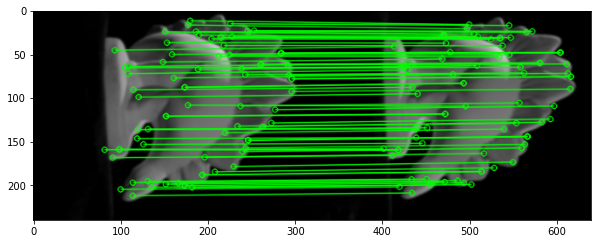

296.2946
76


In [11]:
world_coord = get_world_coord('dino0002.png','dino0001.png', 'dino_par.txt', image_numbers=(2-1, 1-1))

In [12]:
  plot_pointCloud(world_coord)

In [13]:
def plot_pointCloud(pc, path='plot.html'):
    '''
    plots the Nx6 point cloud pc in 3D
    assumes (1,0,0), (0,1,0), (0,0,-1) as basis
    '''
    fig = go.Figure(data=[go.Scatter3d(
        x=pc[:, 0],
        y=pc[:, 1],
        z=-pc[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color=pc[:, 3:][..., ::-1],
            opacity=0.8
        )
    )])
    fig.write_html(path)
    #fig.show()

In [14]:
def get_image_properties(path0, path1, calibration_filepath, image_numbers):
  downsampling_factor = 1
  img0, img1 = get_images(path0, path1, downsampling_factor)
  rgb0 = cv2.imread(path0)

  # Acquire camera information
  calib_vals = extract_calibration_vals(calibration_filepath, image_numbers)
  K0 = calib_vals['cam0']
  K1 = calib_vals['cam1']
  f = K0[0,0]
  
  R0 = calib_vals['R0']
  R1 = calib_vals['R1']

  t0 = calib_vals['t0']
  t1 = calib_vals['t1']

  R1_camera_coord_0 = R0.transpose() @ R1
  t1_camera_coord_0 = t1-t0

  # Extract matching points from the imgs
  img0_pts, img1_pts = perform_SIFT(img0, img1, threshold=0.75)

  # fundamental matrix
  KRt = K0 @ R1_camera_coord_0 @ t1_camera_coord_0
  cross_product_matrix_KRt = np.asarray([[0, -KRt[2][0], KRt[1][0]], [KRt[2][0], 0, -KRt[0][0]], [-KRt[1][0], KRt[0][0], 0]])

  F = np.linalg.inv(K1).transpose() @ R1_camera_coord_0 @ K0.transpose() @ cross_product_matrix_KRt

  # epipoles
  F_U, F_sigma, F_V = np.linalg.svd(F)

  null_F_index = np.argmin(F_sigma)

  e0 = F_V[null_F_index]
  e1 = F_U[:, null_F_index]

  #print(e0, e1)

  # homography matrices
  #e0_temp = -K0 @ R1_camera_coord_0.transpose() @ t1_camera_coord_0
  #e1_temp = -K1 @ t1_camera_coord_0
  
  #e0_normalized = (e0_temp / e0_temp[2]).reshape(3)
  #e1_normalized = (e1_temp / e1_temp[2]).reshape(3)
  
  e0_normalized = e0 / e0[2]
  e0_u = e0_normalized[0]
  e0_v = e0_normalized[1]

  e1_normalized = e1 / e1[2]
  e1_u = e1_normalized[0]
  e1_v = e1_normalized[1]

  #print(e0_normalized, e1_normalized)

  #H0 = np.asarray([[1, 0, 0], [-e0_v/e0_u, 1, 0], [-1/e0_u, 0, 1]])

  #print(H0)

  # Hartley's solution for H1
  #cross_product_matrix_e0 = np.asarray([[0, 0, 0], [0, 0, -e0_u], [0, e0_u, 0]])
  #H1 = H0 @ (cross_product_matrix_e0 @ F + np.asarray([[e0_u, 0, 0]]) @ np.asarray([[e1_u, 0, 0]]).transpose())

  #H1 = H0 @ R1_camera_coord_0.transpose()

  #print(H1)


  # unit_vec_1 = (t1_camera_coord_0 / np.linalg.norm(t1_camera_coord_0))
  # unit_vec_2 = (1/(np.sqrt(t1_camera_coord_0[0][0]**2 + t1_camera_coord_0[1][0]**2)) * np.asarray([[-t1_camera_coord_0[1][0]], [t1_camera_coord_0[0][0]], [0]]))
  # unit_vec_3 = np.cross(unit_vec_1, unit_vec_2, axis=0)

  # H0 = np.concatenate([unit_vec_1, unit_vec_2, unit_vec_3], axis=1).transpose()

  # H1 = R1_camera_coord_0 @ H0


  F, mask = cv2.findFundamentalMat(img0_pts, img1_pts, cv2.FM_RANSAC)

  # Use opencv homography:
  thresh = 0
  height, width = img0.shape
  _, H0, H1 = cv2.stereoRectifyUncalibrated(
      np.float32(img0_pts), np.float32(img1_pts), F, imgSize=(width, height), threshold=thresh,
  )

  return (f, F, e0_normalized, e1_normalized, H0, H1)

<Figure size 432x288 with 0 Axes>

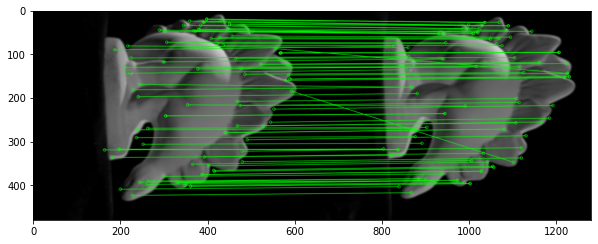

[[ 8.35591067e-06 -1.01771231e-05 -2.71503437e-01]
 [ 1.87034906e-05 -1.79808224e-06  4.65273982e-02]
 [ 2.64455423e-01 -4.64896669e-02  1.00000000e+00]]
[[-5.49169347e-02 -2.60615169e-01 -5.49259827e+00]
 [ 2.66867850e-01 -5.13647523e-02 -1.37779666e+02]
 [ 4.57965759e-06 -9.44779060e-06 -2.69475639e-01]]
[[ 1.92931688e-01  1.00514715e+00  1.70265443e+01]
 [-9.78750923e-01  2.05808543e-01  5.03806245e+02]
 [ 1.38406265e-05  7.21077310e-05  9.78265144e-01]]


In [15]:
def rectification(image1_path, image2_path, paramaters_path, image_numbers):
  f, F, e0, e1, H0, H1 = get_image_properties(image1_path, image2_path, paramaters_path, image_numbers)

  print(F)
  print(H0)
  print(H1)

  img0, img1 = get_images(image1_path, image2_path, 1)

  rgb0 = cv2.imread(image1_path)
  rgb1 = cv2.imread(image2_path)

  def get_point_cloud(grayscale_image_matrix, rgb_image_matrix, homography_matrix):
    lenx = grayscale_image_matrix.shape[0]
    leny = grayscale_image_matrix.shape[1]

    img_pixels = np.zeros((lenx, leny, 3))
    for x in range(lenx):
      for y in range(leny):
        img_pixels[x,y] = [(leny - y), x, f]
    img_pixels = img_pixels.reshape(-1, 3)
    rgb_image_matrix = rgb_image_matrix.reshape(-1, 3)

    projected_img = np.zeros(img_pixels.shape)
    for pixel_index, pixel in enumerate(img_pixels):
      projected_pixel = homography_matrix @ pixel
      projected_img[pixel_index] = (projected_pixel / projected_pixel[-1]) * f

    colour_point_cloud = np.zeros((lenx * leny, 6))
    for point_index in range(projected_img.shape[0]):
      colour_point_cloud[point_index, 0:3] = [-projected_img[point_index, 0], -projected_img[point_index, 1], projected_img[point_index, 2]]
      colour_point_cloud[point_index, 3:] = rgb_image_matrix[point_index]

    return colour_point_cloud

  img0_point_cloud = get_point_cloud(img0, rgb0, H0)
  img1_point_cloud = get_point_cloud(img1, rgb1, H1)

  return (img0_point_cloud, img1_point_cloud)

pc0, pc1 = rectification('dino0002.png', 'dino0001.png', 'dino_par.txt', image_numbers=(2-1, 1-1))

In [50]:
array = np.array([[1,2,3],
                  [2,3,4],
                  [4,5,6]])
array += np.array([1,2,3])
print(array)

[[2 4 6]
 [3 5 7]
 [5 7 9]]


<Figure size 432x288 with 0 Axes>

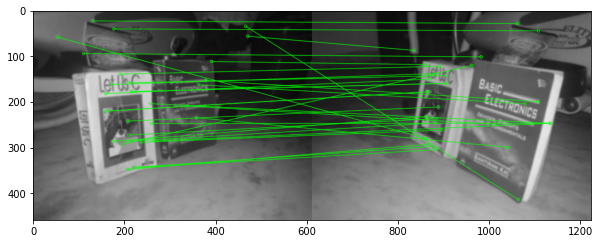

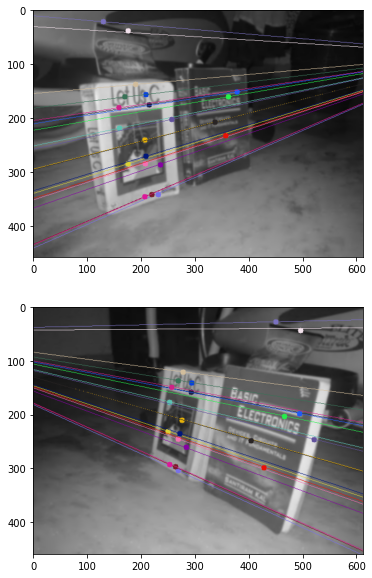

[250.2019043  232.23071289   1.        ]
[176.52264404 286.46160889   1.        ]
-0.007843657049329877
[253.7361145  178.21762085   1.        ]
[160.10914612 220.57582092   1.        ]
0.0003838844748029757
[253.7361145  178.21762085   1.        ]
[160.00270081 220.51835632   1.        ]
-0.0009565267985056636
[293.76327515 159.83135986   1.        ]
[215.70098877 177.8399353    1.        ]
0.0023704324165780832
[293.76327515 159.83135986   1.        ]
[215.60499573 177.72319031   1.        ]
2.1760371282653068e-14
[494.20727539 199.8009491    1.        ]
[378.23043823 153.43769836   1.        ]
-0.003701912196510726
[276.94137573 211.44737244   1.        ]
[207.51968384 242.30133057   1.        ]
-0.011366184645885014
[278.37945557 122.61096191   1.        ]
[190.82736206 139.72688293   1.        ]
-0.003483318857306017
[[-1.79258966e-06  2.97088221e-05 -9.97759083e-04]
 [ 3.38363537e-05  3.15256106e-06 -2.82099340e-02]
 [-2.09796171e-03  8.78435831e-03  1.00000000e+00]]
[[-3.3065042

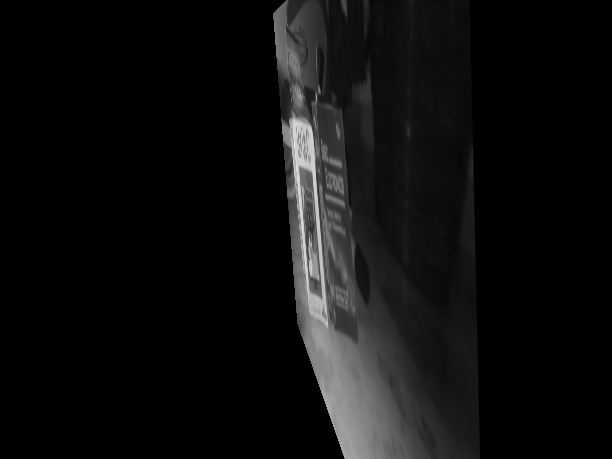

hmmmmm


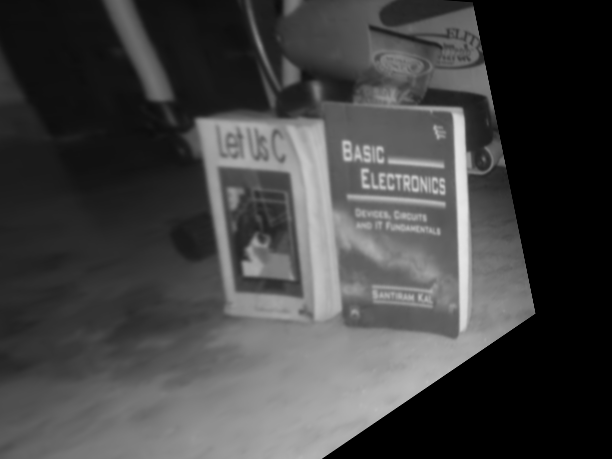

In [81]:
# from opencv documentation:
def drawlines(img1,img2,lines,pts1,pts2,colors):
  ''' img1 - image on which we draw the epilines for the points in img2
      lines - corresponding epilines '''
  r,c = img1.shape
  img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
  img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
  i=0
  for r,pt1,pt2 in zip(lines,pts1,pts2):
    color = colors[i]
    i += 1
    #color = tuple(np.random.randint(0,255,3).tolist())
    x0,y0 = map(int, [0, -r[2]/r[1] ])
    x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
    #print(r)
    img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
    img1 = cv2.circle(img1,tuple(pt1[0]),5,color,-1)
    img2 = cv2.circle(img2,tuple(pt2[0]),5,color,-1)
  return img1,img2

# for drawing lines when F is not calculated from the points
def drawlines_indep(img1,img2,lines,pts1,pts2,colors):
  ''' img1 - image on which we draw the epilines for the points in img2
      lines - corresponding epilines '''
  r,c = img1.shape
  img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
  img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
  i=0
  for r,pt1,pt2 in zip(lines,pts1,pts2):
    color = colors[i]
    i += 1
    #color = tuple(np.random.randint(0,255,3).tolist())
    x0,y0 = map(int, [pt1[0,0], -r[2]/r[1] ])
    x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
    #print(r)
    img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
    img1 = cv2.circle(img1,tuple(pt1[0]),5,color,-1)
    img2 = cv2.circle(img2,tuple(pt2[0]),5,color,-1)
  return img1,img2

def show_epipolar_lines_nomask(pts0, pts1, F, img1, img2):
  # We select only inlier points
  pts0 = np.int32(pts0)
  pts1 = np.int32(pts1)

  #print("epilines")

  # Acquire colors:
  colors = []
  for i in range(len(pts0)):
    color = tuple(np.random.randint(0,255,3).tolist())
    colors.append(color)

  # Find epilines corresponding to points in right image (second image) and
  # drawing its lines on left image
  lines1 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 2,F)
  lines1 = lines1.reshape(-1,3)
  img5,img6 = drawlines_indep(img1,img2,lines1,pts0,pts1,colors)

  # Find epilines corresponding to points in left image (first image) and
  # drawing its lines on right image
  lines2 = cv2.computeCorrespondEpilines(pts0.reshape(-1,1,2), 1,F)
  lines2 = lines2.reshape(-1,3)
  img3,img4 = drawlines_indep(img2,img1,lines2,pts1,pts0,colors)

  # plt.subplot(121),plt.imshow(img5)
  # plt.subplot(122),plt.imshow(img3)
  fig, axs = plt.subplots(2,figsize=(10, 10))
  axs[0].imshow(img5)
  axs[1].imshow(img3)
  plt.show()

def show_epipolar_lines(pts0, pts1, F, mask, img1, img2):
  # We select only inlier points
  pts0 = np.int32(pts0)
  pts1 = np.int32(pts1)
  pts0 = pts0[mask.ravel()==1]
  pts1 = pts1[mask.ravel()==1]

  # Acquire colors:
  colors = []
  for i in range(len(pts0)):
    color = tuple(np.random.randint(0,255,3).tolist())
    colors.append(color)

  # Find epilines corresponding to points in right image (second image) and
  # drawing its lines on left image
  lines1 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 2,F)
  lines1 = lines1.reshape(-1,3)
  img5,img6 = drawlines(img1,img2,lines1,pts0,pts1,colors)

  # Find epilines corresponding to points in left image (first image) and
  # drawing its lines on right image
  lines2 = cv2.computeCorrespondEpilines(pts0.reshape(-1,1,2), 1,F)
  lines2 = lines2.reshape(-1,3)
  img3,img4 = drawlines(img2,img1,lines2,pts1,pts0,colors)

  # plt.subplot(121),plt.imshow(img5)
  # plt.subplot(122),plt.imshow(img3)
  fig, axs = plt.subplots(2,figsize=(10, 10))
  axs[0].imshow(img5)
  axs[1].imshow(img3)
  plt.show()

# def compute_F_H_opencv(path0, path1, calibration_filepath, image_numbers):
#   downsampling_factor = 1
#   img0, img1 = get_images(path0, path1, downsampling_factor)
#   # img0 = np.transpose(img0)
#   # img1 = np.transpose(img1)
#   rgb0 = cv2.imread(path0)

#   # Extract matching points from the imgs
#   img0_pts, img1_pts = perform_SIFT(img0, img1, threshold=0.75)

#   # # Acquire camera information
#   calib_vals = extract_calibration_vals(calibration_filepath, image_numbers)
#   K0 = calib_vals['cam0']
#   K1 = calib_vals['cam1']
#   f = K0[0,0]
  
#   R0 = calib_vals['R0']
#   R1 = calib_vals['R1']

#   t0 = calib_vals['t0']
#   t1 = calib_vals['t1']

#   R1_camera_coord_0 = R0.transpose() @ R1
#   t1_camera_coord_0 = t1-t0

#   # # fundamental matrix
#   # KRt = K0 @ R1_camera_coord_0 @ t1_camera_coord_0
#   # cross_product_matrix_KRt = np.asarray([[0, -KRt[2][0], KRt[1][0]], [KRt[2][0], 0, -KRt[0][0]], [-KRt[1][0], KRt[0][0], 0]])

#   # F = np.linalg.inv(K1).transpose() @ R1_camera_coord_0 @ K0.transpose() @ cross_product_matrix_KRt
#   # show_epipolar_lines_nomask(img0_pts, img1_pts, F, img0, img1)

#   F, mask = cv2.findFundamentalMat(img0_pts, img1_pts, cv2.FM_RANSAC)
#   show_epipolar_lines(img0_pts, img1_pts, F, mask, img0, img1)

#   #Use opencv homography:
#   thresh = 0
#   height, width = img0.shape
#   _, H0, H1 = cv2.stereoRectifyUncalibrated(
#       np.float32(img0_pts), np.float32(img1_pts), F, imgSize=(width, height), threshold=thresh,
#   )
#   # _, H0, H1 = cv2.stereoRectifyUncalibrated(
#   #     np.float32(img0_pts), np.float32(img1_pts), F, imgSize=img0.shape, threshold=thresh,
#   # )

#   # Or calculate homography matrix manually
#   # unit_vec_1 = (t1_camera_coord_0 / np.linalg.norm(t1_camera_coord_0))
#   # unit_vec_2 = (1/(np.sqrt(t1_camera_coord_0[0][0]**2 + t1_camera_coord_0[1][0]**2)) * np.asarray([[-t1_camera_coord_0[1][0]], [t1_camera_coord_0[0][0]], [0]]))
#   # unit_vec_3 = np.cross(unit_vec_1, unit_vec_2, axis=0)

#   # H0 = np.concatenate([unit_vec_1, unit_vec_2, unit_vec_3], axis=1).transpose()

#   # H1 = R1_camera_coord_0 @ H0

#   return F, H0, H1

def compute_F_H_opencv2(path0, path1, calibration_filepath, image_numbers):
  downsampling_factor = 1
  img0, img1 = get_images(path0, path1, downsampling_factor)
  # img0 = np.transpose(img0)
  # img1 = np.transpose(img1)
  rgb0 = cv2.imread(path0)

  # Extract matching points from the imgs
  img0_pts, img1_pts = perform_SURF(img0, img1, threshold=0.7)

  # # Acquire camera information
  calib_vals = extract_calibration_vals(calibration_filepath, image_numbers)
  K0 = calib_vals['cam0']
  K1 = calib_vals['cam1']
  f = (K0[0,0]+K0[0,0])/2
  
  R0 = calib_vals['R0']
  R1 = calib_vals['R1']

  t0 = calib_vals['t0']
  t1 = calib_vals['t1']

  # textbook methods
  R_btwn = R1 @ (R0.transpose())
  t_btwn = t0 - R_btwn.transpose()@t1

  # general methods
  #R_btwn = np.linalg.inv(R1) @ R0
  # R_btwn = R0.transpose()@R1
  # t_btwn = t1-t0

  # print(R_btwn)
  # print(t_btwn)
  # print(t_btwn[2,0])
  # print(t_btwn[1,0])

  # # # fundamental matrix
  # # define using E = RS, E is rank 2, and is the essential matrix
  # S = np.array([[0,-t_btwn[2][0],t_btwn[1][0]],
  #               [t_btwn[2][0],0,-t_btwn[0][0]],
  #               [-t_btwn[1][0],t_btwn[0][0],0]])
  
  # #E = R_btwn@S
  # E = S@R_btwn
  # F = np.linalg.inv(K1).transpose() @ E @ np.linalg.inv(K0)
  # #F = F/F[2,2]
  # show_epipolar_lines_nomask(img0_pts, img1_pts, F, img0, img1)


  # KRt = K0 @ R_btwn @ t_btwn
  # cross_product_matrix_KRt = np.asarray([[0, -KRt[2][0], KRt[1][0]], [KRt[2][0], 0, -KRt[0][0]], [-KRt[1][0], KRt[0][0], 0]])

  # F = np.linalg.inv(K1).transpose() @ R_btwn @ K0.transpose() @ cross_product_matrix_KRt
  # show_epipolar_lines_nomask(img0_pts, img1_pts, F, img0, img1)

  F, mask = cv2.findFundamentalMat(img0_pts, img1_pts, cv2.FM_RANSAC)
  show_epipolar_lines(img0_pts, img1_pts, F, mask, img0, img1)

  # check if x'Fx = 0
  for i in range(8):
    n1 = np.array([img1_pts[i,0,0],img1_pts[i,0,1],1])
    n0 = np.array([img0_pts[i,0,0],img0_pts[i,0,1],1])
    print(n1)
    print(n0)
    print(n1.transpose()@F@n0)

  # Use opencv homography:
  thresh = 0
  height, width = img0.shape
  _, H0, H1 = cv2.stereoRectifyUncalibrated(
      np.float32(img0_pts), np.float32(img1_pts), F, imgSize=(width, height), threshold=thresh,
  )
  # _, H0, H1 = cv2.stereoRectifyUncalibrated(
  #     np.float32(img0_pts), np.float32(img1_pts), F, imgSize=img0.shape, threshold=thresh,
  # )

  # # Or calculate homography matrix manually
  # unit_vec_1 = (t_btwn / np.linalg.norm(t_btwn))
  # unit_vec_2 = (1/(np.sqrt(t_btwn[0][0]**2 + t_btwn[1][0]**2)) * np.asarray([[-t_btwn[1][0]], [t_btwn[0][0]], [0]]))
  # unit_vec_3 = np.cross(unit_vec_1, unit_vec_2, axis=0)
  # print(unit_vec_1)

  # # u,s,vh = np.linalg.svd(E)
  # # print("SVD:")
  # # print(u)
  # # print(s)
  # # print(vh)

  # H0 = np.concatenate([unit_vec_1, unit_vec_2, unit_vec_3], axis=1).transpose()

  # H1 = R_btwn@H0

  return F, H0, H1, f, K0, K1

def rectify_image(img, img_rgb, F, H, f, pad=600, px=0, py=0):
  height, width = img.shape
  print("image shape")
  print(img.shape)
  rect_pixels = np.zeros([height, width, 5])

  new_frame = np.zeros([height+pad*2, width+pad*2, 3])
  print(new_frame.shape)

  for y in range(height):
    for x in range(width):
      p = H@np.array([x,y,f])
      p_dot = p*(f/p[2])
      x_new = int(p_dot[0]) + pad
      y_new = int(p_dot[1]) + pad
      if x_new >= 0 and x_new < width+2*pad and y_new >= 0 and y_new < height+2*pad:
        new_frame[y_new,x_new,:] = img_rgb[y,x,:]
        #new_frame[y_new,x_new,:] = img[y,x]

  # f = plt.figure(figsize=(10,10))
  # plt.imshow(new_frame)
  # plt.show()
  cv2_imshow(new_frame)

# set centre of img to be px,py
def rectify_image2(img, img_rgb, F, H, f, pad=600, px=0, py=0):
  height, width = img.shape
  print("image shape")
  print(img.shape)
  rect_pixels = np.zeros([height, width, 5])

  new_frame = np.zeros([height+pad*2, width+pad*2, 3])
  print(new_frame.shape)

  for y in range(height):
    for x in range(width):
      p = H@np.array([x-px,y-py,f])
      p_dot = p*(f/p[2])
      x_new = int(p_dot[0] + px) + pad
      y_new = int(p_dot[1] + py) + pad
      if x_new >= 0 and x_new < width+2*pad and y_new >= 0 and y_new < height+2*pad:
        new_frame[y_new,x_new,:] = img_rgb[y,x,:]
        #new_frame[y_new,x_new,:] = img[y,x]

  # f = plt.figure(figsize=(10,10))
  # plt.imshow(new_frame)
  # plt.show()
  cv2_imshow(new_frame)

  



def get_rectified_images(path0, path1, paramaters_path, image_numbers):
  F, H0, H1, f, K0, K1 = compute_F_H_opencv2(path0, path1, paramaters_path, image_numbers)
  print(F)
  print(H0)
  print(H1)
  print(f)
  downsampling_factor = 1
  img0, img1 = get_images(path0, path1, downsampling_factor)
  rgb0 = cv2.imread(path0)
  rgb1 = cv2.imread(path1)
  height0, width0 = img0.shape
  height1, width1 = img1.shape

  #f -= 2000
  px = K0[0,2]
  py = K1[1,2]
  print("px and py")
  print(px)
  print(py)

  # pad=600

  # rectify_image(img0, rgb0, F, H0, f, pad, px, py)
  # print("hmmmmm")
  # rectify_image(img1, rgb1, F, H1, f, pad, px, py)

  img0_rectified = cv2.warpPerspective(img0, H0, (width0, height0))
  img1_rectified = cv2.warpPerspective(img1, H1, (width1, height1))
  cv2_imshow(img0_rectified)
  print("hmmmmm")
  cv2_imshow(img1_rectified)

  # # img0_rectified = cv2.warpPerspective(img0, H0, img0.shape)
  # # img1_rectified = cv2.warpPerspective(img1, H1, img1.shape)

  # cv2.imwrite("img0_rectified.png", img0_rectified)
  # cv2.imwrite("img1_rectified.png", img1_rectified)

def reverse_rectify_image(img, img_rgb, F, H, f, pad=600):
  height, width = img.shape
  rect_pixels = np.zeros([height, width, 5])

  new_frame = np.zeros([height+pad*2, width+pad*2, 3])
  new_height, new_width, _ = new_frame.shape

  H_inv = np.linalg.inv(H)

  for y in range(new_height):
    for x in range(new_width):
      p = H_inv@np.array([x,y,f])
      p_dot = p*(f/p[2])
      x_old = int(p_dot[0])
      y_old = int(p_dot[1])
      if x_old >= 0 and x_old < width and y_old >= 0 and y_old < height:
        new_frame[y,x,:] = img_rgb[y_old,x_old,:]

  cv2_imshow(new_frame)

# 
def get_reverse_rectified_images(path0, path1, paramaters_path, image_numbers, new_f=1):
  F, H0, H1, f = compute_F_H_opencv2(path0, path1, paramaters_path, image_numbers)
  print(F)
  print(H0)
  print(H1)
  print(f)
  downsampling_factor = 1
  img0, img1 = get_images(path0, path1, downsampling_factor)
  rgb0 = cv2.imread(path0)
  rgb1 = cv2.imread(path1)
  height0, width0 = img0.shape
  height1, width1 = img1.shape

  new_f = f

  reverse_rectify_image(img0, rgb0, F, H0, new_f)
  print("hmmmmm")
  reverse_rectify_image(img1, rgb1, F, H1, new_f)

get_rectified_images('booksL.jpg', 'booksR.jpg', 'dino_par.txt', image_numbers=(4-1, 1-1))
#get_rectified_images('dino0004.png', 'dino0001.png', 'dino_par.txt', image_numbers=(4-1, 1-1))
#get_rectified_images('templeR0001.png', 'templeR0003.png', 'templeR_par.txt', image_numbers=(1-1, 3-1))
#get_reverse_rectified_images('dino0004.png', 'dino0001.png', 'dino_par.txt', image_numbers=(4-1, 1-1))

<Figure size 432x288 with 0 Axes>

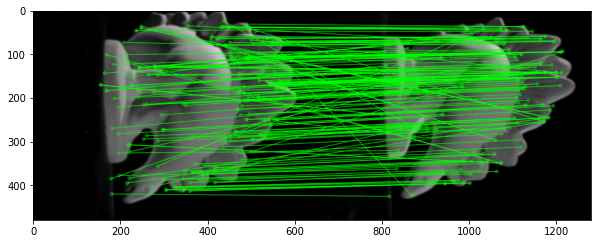

[[ 0.93780904 -0.01845498 -0.34666287]
 [ 0.01549951  0.99981607 -0.01129536]
 [ 0.346808    0.00522105  0.93792038]]
[[9.62068283e-06]
 [8.16931522e-04]
 [2.07605416e-03]]


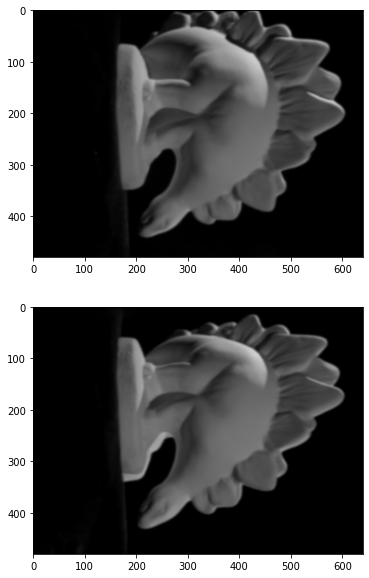

[445.47335815  46.39791489   1.        ]
[448.68026733  39.07948685   1.        ]
0.00031747905684916065
[504.90084839  48.26864243   1.        ]
[508.89447021  48.97115707   1.        ]
0.000315496712702262
[304.75634766 396.53012085   1.        ]
[304.66934204 409.65737915   1.        ]
0.00023860163194776282
[304.75634766 396.53012085   1.        ]
[304.90457153 411.47836304   1.        ]
0.00023817013147779876
[438.57492065  77.79309082   1.        ]
[440.30599976  80.3020401    1.        ]
0.00030888720130978545
[197.99157715 320.5625       1.        ]
[195.70880127 326.40112305   1.        ]
0.00025677457528462634
[573.79888916  94.67385101   1.        ]
[574.39465332 104.86097717   1.        ]
0.00030498327581231417
[569.22711182  95.7114563    1.        ]
[569.97167969 106.11623383   1.        ]
0.00030462101189650216
[[ 2.23461916e-11 -1.77157272e-10  2.59934783e-07]
 [ 1.89385957e-10 -2.91949017e-12 -5.84836217e-08]
 [-2.73242223e-07 -1.57096514e-07  3.27816549e-04]]
[[ 0.004

In [18]:
def rectification_v2(image1_path, image2_path, paramaters_path, image_numbers):
  F, H0, H1, f = compute_F_H_opencv2(image1_path, image2_path, paramaters_path, image_numbers)

  print(F)
  print(H0)
  print(H1)

  img0, img1 = get_images(image1_path, image2_path, 1)

  rgb0 = cv2.imread(image1_path)
  rgb1 = cv2.imread(image2_path)

  def get_point_cloud(grayscale_image_matrix, rgb_image_matrix, homography_matrix):
    lenx = grayscale_image_matrix.shape[0]
    leny = grayscale_image_matrix.shape[1]

    img_pixels = np.zeros((lenx, leny, 3))
    for x in range(lenx):
      for y in range(leny):
        img_pixels[x,y] = [(leny - y), x, f]
    img_pixels = img_pixels.reshape(-1, 3)
    rgb_image_matrix = rgb_image_matrix.reshape(-1, 3)

    projected_img = np.zeros(img_pixels.shape)
    for pixel_index, pixel in enumerate(img_pixels):
      projected_pixel = homography_matrix @ pixel
      projected_img[pixel_index] = (projected_pixel / projected_pixel[-1]) * f

    colour_point_cloud = np.zeros((lenx * leny, 6))
    for point_index in range(projected_img.shape[0]):
      colour_point_cloud[point_index, 0:3] = [-projected_img[point_index, 0], -projected_img[point_index, 1], projected_img[point_index, 2]]
      colour_point_cloud[point_index, 3:] = rgb_image_matrix[point_index]

    return colour_point_cloud

  img0_point_cloud = get_point_cloud(img0, rgb0, H0)
  img1_point_cloud = get_point_cloud(img1, rgb1, H1)

  return (img0_point_cloud, img1_point_cloud)

pc0, pc1 = rectification_v2('dino0004.png', 'dino0001.png', 'dino_par.txt', image_numbers=(4-1, 1-1))
plot_pointCloud(pc0, 'plot_dino0001.html')
plot_pointCloud(pc1, 'plot_dino0002.html')


In [19]:
# Broken at the moment

def reverse_rectification(image1_path, image2_path, paramaters_path):
  f, F, e0, e1, H0, H1 = get_image_properties(image1_path, image2_path, paramaters_path)

  img0, img1 = get_images(image1_path, image2_path, 1)

  rgb0 = cv2.imread(image1_path)
  rgb1 = cv2.imread(image2_path)

  def get_point_cloud(grayscale_image_matrix, rgb_image_matrix, homography_matrix):
    lenx = grayscale_image_matrix.shape[0]
    leny = grayscale_image_matrix.shape[1]

    img_pixels = np.zeros((lenx, leny, 5))
    for x in range(lenx):
      for y in range(leny):
        img_pixels[x,y] = [leny - y, x, leny - y, x, f]
    img_pixels = img_pixels.reshape(-1, 5)

    projected_img = np.zeros(img_pixels.shape)
    for pixel_index, pixel in enumerate(img_pixels):
      projected_pixel = np.linalg.inv(homography_matrix) @ pixel[2:]
      projected_img[pixel_index, 2:] = projected_pixel / f
      projected_img[pixel_index, 0:2] = pixel[0:2]

    print(np.max(projected_img[2]))
    print(np.max(projected_img[3]))

    colour_point_cloud = np.zeros((lenx * leny, 6))
    for point_index in range(projected_img.shape[0]):
      colour_point_cloud[point_index, 0:3] = [-projected_img[point_index, 0], -projected_img[point_index, 1], 0]
      try:
        colour_point_cloud[point_index, 3:] = rgb_image_matrix[projected_img[point_index, 2].astype(int), projected_img[point_index, 3].astype(int)]
      except Exception:
        print(projected_img[point_index, 2:4].astype(int))
        raise

    return colour_point_cloud

  img0_point_cloud = get_point_cloud(img0, rgb0, H0)
  img1_point_cloud = get_point_cloud(img1, rgb1, H1)

  return (img0_point_cloud, img1_point_cloud)

#pc0, pc1 = reverse_rectification('dino0001.png', 'dino0002.png', 'dino_par.txt')

In [20]:
plot_pointCloud(pc0, 'plot_dino0001.html')

In [21]:
plot_pointCloud(pc1, 'plot_dino0002.html')

In [22]:
base_image_0_rgb = cv2.imread("dino0002.png")

image_len_x, image_len_y, _ = base_image_0_rgb.shape

pixels_image_0 = np.zeros((image_len_x, image_len_y, 6))
for x in range(image_len_x):
  for y in range(image_len_y):
    pixels_image_0[x,y] = [ image_len_y - y, x, 1, base_image_0_rgb[x, y, 0], base_image_0_rgb[x, y, 1], base_image_0_rgb[x, y, 2]]
pixels_image_0 = pixels_image_0.reshape(-1, 6)

plot_pointCloud(pixels_image_0)

In [23]:
base_image_0_rgb.shape

(480, 640, 3)